# **Diabetic Retinopathy Detection**
****Identify signs of diabetic retinopathy in eye images****


Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4104/media/retina.jpg)


The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

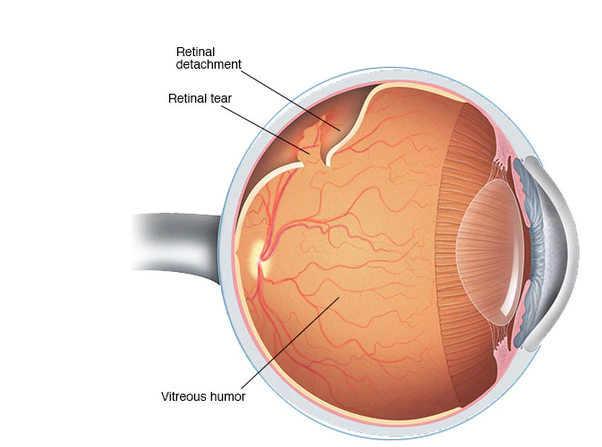

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. 

DR: Diabetic Retinopathy

https://www.kaggle.com/competitions/diabetic-retinopathy-detection

# ****About Dataset****
****About the Data****

The images consist of gaussian filtered retina scan images to detect diabetic retinopathy. The original dataset is available at APTOS 2019 Blindness Detection. These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.

All of the images are already saved into their respective folders according to the severity/stage of diabetic retinopathy using the train.csv file provided. You will find five directories with the respective images:

****0 - No_DR****

****1 - Mild****

****2 - Moderate****

****3 - Severe****

****4 - Proliferate_DR****



![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4e2ccbd15cc04a08c9a096424043c4aee7c4388b/2-Figure1-1.png)

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

In [ ]:
df['type'].value_counts().plot(kind='barh')

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


In [ ]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

In [ ]:
model.save('64x3-CNN.model')

In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


# ****Diabet Retinopathy Detection Section****

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')
    

    

In [ ]:
predict_class('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png')